# Model Specifications

## Host Specifications

The host may be in one of 4 states:

- susceptible (S_H)

- incubation period (E_H)

- infectious (I_H)

- recovered (R_H)

## Vector Specifications 

The vector may be in one of 3 states:

- susceptible (S_V)

- incubation period (E_V)

- infectious (I_V)

# Model Parameters

σ_H, σ_V: the incubation rates for hosts & vectors (units: per time)

μ_H, μ_V: the mortality rates for hosts & vectors (units: per time)

λ: the clearance (or recovery) rate for hosts (units: per time)

β: the infection rate (units: per capita per time)

$$N_H^i = S_H^i + E_H^i + I_H^i + R_H^i, \dot{N_H^i}=0$$

$$N_H = \sum_{i=1}^N N_H^i$$

$$\dot{S_H}^i = \mu_H^i(E_H^i + I_H^i + R_H^i) - \frac{\beta^i}{N_H} S_H^i I_V$$

$$\dot{E_H}^i = \frac{\beta^i}{N_H} S_H^i I_V - (\sigma_H^i + \mu_H^i) E_H^i$$

$$\dot{I_H}^i = \sigma_H^i E_H^i - (\lambda^i + \mu_H^i) I_H^i$$

$$\dot{R_H}^i = \lambda^i I_H^i - \mu_H^i R_H^i$$

$$\dot{S_V} = \mu_V(E_V + I_V) - \frac{\sum_{i=1}^N\beta^i I_H^i}{N_H} S_V$$

$$\dot{E_V} = \frac{\sum_{i=1}^N\beta^i I_H^i}{N_H} S_V - (\sigma_V + \mu_V) E_V$$

$$\dot{I_V} = \sigma_V E_V - \mu_V I_V$$

This version considers multiple hosts, which introduces some indexing complications. This approach adopts the indexing scheme of:

- all of host $i$ compartments ($S_H$, $E_H$, etc), for $i∈1…N$
- vector compartments last
With this approach, we can re-use the solution for one host, with slight modifications:

In [60]:
H_comps = 4
V_comps = 3

# in sub functions, du / u are the particular relevant slices only
function F1H(du,u,p,t,I_V,N_H)
    S_H, E_H, I_H, R_H = u
    
    # host dynamics
    host_infection = (p.β*S_H*I_V)/N_H
    host_mortality = p.μ_H .* u # include S_H, so easier to remove mortality
    host_births = sum(host_mortality)
    host_progression = p.σ_H*E_H
    recovery = p.λ*I_H
    
    du[1] = -host_infection + host_births
    du[2] = host_infection - host_progression
    du[3] = host_progression - recovery
    du[4] = recovery
    du[1:end] -= host_mortality 
end

# in sub functions, du / u are the particular relevant slices only
function FV(du,u,p,t,sum_β_I_H)
    S_V, E_V, I_V = u
    vec_infection = sum_β_I_H*S_V/p.N_H
    vec_mortality = p.μ_V .* u # include S_V, so easier to remove mortality
    vec_births = sum(vec_mortality)
    vec_progression = p.σ_V*E_V
    
    du[1] = -vec_infection + vec_births
    du[2] = vec_infection - vec_progression
    du[3] = vec_progression
    du[1:end] -= vec_mortality
end

function F(du,u,p,t)
    uvec = @view(u[(p.nHosts*H_comps+1):end]) # grab the vector compartments
    S_V, E_V, I_V = uvec
    sum_β_I_H = 0.0
    for host in 0:(p.nHosts-1)
        slice = (1:H_comps).+(H_comps*host)
        F1H(@view(du[slice]), @view(u[slice]), p.host[host+1], t, I_V, p.vec.N_H)
        # must use @view here, so that these arrays can be modified in F1H
        sum_β_I_H += p.host[host+1].β * u[slice[3]] # this host's I compartment
    end
    FV(@view(du[(p.nHosts*4+1):end]), uvec, p.vec,t,sum_β_I_H)
end

F (generic function with 1 method)

First, state initial conditions. This code generates them randomly for convenience, though they could be assigned based on data, desired parameter space, or algorithmically as part of a fitting process:

In [76]:
using Random
nH = 5
Random.seed!(0)

S_Hs = ones(nH) .* 100.0
E_Hs = zeros(nH)
I_Hs = shuffle(vcat(zeros(nH-1),[1.0]))
R_Hs = zeros(nH)
host0 = reshape(hcat(S_Hs,E_Hs,I_Hs,R_Hs)', nH*4, 1)
vec0 = [10000.0, 0.0, 0.0]
u0 = vcat(host0, vec0);

Now, generate dynamic parameters. Again: this code generates them randomly for convenience, though they could be assigned based on data, desired parameter space, or algorithmically as part of a fitting process:

In [62]:
Random.seed!(1)

μs = 1 ./ (rand(nH) .* 360)
σs = 1 ./ (rand(nH) .* 6)
λs = 1 ./ (rand(nH) .* 28)
βs = rand(nH) ./ 10.0



p = (
  nHosts = nH,
  vec = (μ_V=1/30, σ_V=1/7, N_H = sum(host0)),
  host = [(μ_H=μs[i], σ_H=σs[i], λ=λs[i], β=βs[i]) for i in 1:nH]
  # just building up a random collection of params for demonstration
);

In [63]:
using DifferentialEquations
using IterableTables, DataFrames

tspan = (0.0, 365.0)
prob = ODEProblem(F, u0, tspan, p)
sol = solve(prob,Tsit5(),reltol=1e-8,abstol=1e-8,saveat=collect(range(0,stop = 365,length = 365*10+1)));

In [71]:
df = DataFrame(sol)
namespace = zip(names(df)[2:end],[
    :S_H1,:E_H1,:I_H1,:R_H1,
    :S_H2,:E_H2,:I_H2,:R_H2,
    :S_H3,:E_H3,:I_H3,:R_H3,
    :S_H4,:E_H4,:I_H4,:R_H4,
    :S_H5,:E_H5,:I_H5,:R_H5,
    :S_V,:E_V,:I_V])
namespace = collect(namespace)
rename!(df,namespace);

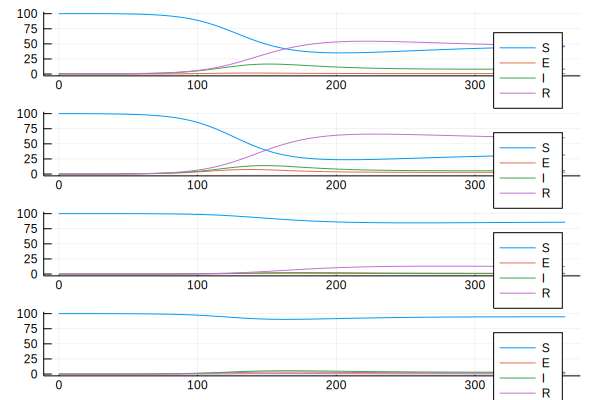

In [94]:
using Plots
host_1 = plot(df[:timestamp],[df[:,:S_H1],df[:,:E_H1],df[:,:I_H1],df[:,:R_H1]])
host_2 = plot(df[:timestamp],[df[:,:S_H2],df[:,:E_H2],df[:,:I_H2],df[:,:R_H2]])
host_3 = plot(df[:timestamp],[df[:,:S_H3],df[:,:E_H3],df[:,:I_H3],df[:,:R_H3]])
host_4 = plot(df[:timestamp],[df[:,:S_H4],df[:,:E_H4],df[:,:I_H4],df[:,:R_H4]])
plot(host_1,host_2,host_3,host_4,layout=(4,1),label=["S","E","I","R"])